In [27]:
import pandas as pd
import numpy as np
%matplotlib inline
pd.set_option("display.max_columns", 111)
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score

from category_encoders import OneHotEncoder

import tensorflow.keras as tfk

In [28]:
data = pd.read_excel('dataset.xlsx')
data['SARS-Cov-2 exam result'] = data['SARS-Cov-2 exam result'].map(dict(negative=0, positive=1))
data.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in data.columns]
data['Urine___pH'] = data['Urine___pH'].map(lambda x: -100 if isinstance(x, str) else x).astype(float)
data['Urine___Leukocytes'] = data['Urine___Leukocytes'].map(lambda x: 500 if x == '<1000' else x).astype(float)






In [29]:
data.head()

,Patient_ID,Patient_age_quantile,SARS_Cov_2_exam_result,Patient_addmited_to_regular_ward__1_yes__0_no_,Patient_addmited_to_semi_intensive_unit__1_yes__0_no_,Patient_addmited_to_intensive_care_unit__1_yes__0_no_,Hematocrit,Hemoglobin,Platelets,Mean_platelet_volume_,Red_blood_Cells,Lymphocytes,Mean_corpuscular_hemoglobin_concentration__MCHC_,Leukocytes,Basophils,Mean_corpuscular_hemoglobin__MCH_,Eosinophils,Mean_corpuscular_volume__MCV_,Monocytes,Red_blood_cell_distribution_width__RDW_,Serum_Glucose,Respiratory_Syncytial_Virus,Influenza_A,Influenza_B,Parainfluenza_1,CoronavirusNL63,Rhinovirus_Enterovirus,Mycoplasma_pneumoniae,Coronavirus_HKU1,Parainfluenza_3,Chlamydophila_pneumoniae,Adenovirus,Parainfluenza_4,Coronavirus229E,CoronavirusOC43,Inf_A_H1N1_2009,Bordetella_pertussis,Metapneumovirus,Parainfluenza_2,Neutrophils,Urea,Proteina_C_reativa_mg_dL,Creatinine,Potassium,Sodium,Influenza_B__rapid_test,Influenza_A__rapid_test,Alanine_transaminase,Aspartate_transaminase,Gamma_glutamyltransferase_,Total_Bilirubin,Direct_Bilirubin,Indirect_Bilirubin,Alkaline_phosphatase,Ionized_calcium_,Strepto_A,Magnesium,pCO2__venous_blood_gas_analysis_,Hb_saturation__venous_blood_gas_analysis_,Base_excess__venous_blood_gas_analysis_,pO2__venous_blood_gas_analysis_,Fio2__venous_blood_gas_analysis_,Total_CO2__venous_blood_gas_analysis_,pH__venous_blood_gas_analysis_,HCO3__venous_blood_gas_analysis_,Rods__,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine___Esterase,Urine___Aspect,Urine___pH,Urine___Hemoglobin,Urine___Bile_pigments,Urine___Ketone_Bodies,Urine___Nitrite,Urine___Density,Urine___Urobilinogen,Urine___Protein,Urine___Sugar,Urine___Leukocytes,Urine___Crystals,Urine___Red_blood_cells,Urine___Hyaline_cylinders,Urine___Granular_cylinders,Urine___Yeasts,Urine___Color,Partial_thromboplastin_time__PTT__,Relationship__Patient_Normal_,International_normalized_ratio__INR_,Lactic_Dehydrogenase,Prothrombin_time__PT___Activity,Vitamin_B12,Creatine_phosphokinase__CPK__,Ferritin,Arterial_Lactic_Acid,Lipase_dosage,D_Dimer,Albumin,Hb_saturation__arterial_blood_gases_,pCO2__arterial_blood_gas_analysis_,Base_excess__arterial_blood_gas_analysis_,pH__arterial_blood_gas_analysis_,Total_CO2__arterial_blood_gas_analysis_,HCO3__arterial_blood_gas_analysis_,pO2__arterial_blood_gas_analysis_,Arteiral_Fio2,Phosphor,ctO2__arterial_blood_gas_analysis_
0,44477f75e8169d2,13,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,0,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f

In [30]:
X = data.iloc[:, 6:]
X['Patient_age_quantile'] = data['Patient_age_quantile']
X.head()

,Hematocrit,Hemoglobin,Platelets,Mean_platelet_volume_,Red_blood_Cells,Lymphocytes,Mean_corpuscular_hemoglobin_concentration__MCHC_,Leukocytes,Basophils,Mean_corpuscular_hemoglobin__MCH_,Eosinophils,Mean_corpuscular_volume__MCV_,Monocytes,Red_blood_cell_distribution_width__RDW_,Serum_Glucose,Respiratory_Syncytial_Virus,Influenza_A,Influenza_B,Parainfluenza_1,CoronavirusNL63,Rhinovirus_Enterovirus,Mycoplasma_pneumoniae,Coronavirus_HKU1,Parainfluenza_3,Chlamydophila_pneumoniae,Adenovirus,Parainfluenza_4,Coronavirus229E,CoronavirusOC43,Inf_A_H1N1_2009,Bordetella_pertussis,Metapneumovirus,Parainfluenza_2,Neutrophils,Urea,Proteina_C_reativa_mg_dL,Creatinine,Potassium,Sodium,Influenza_B__rapid_test,Influenza_A__rapid_test,Alanine_transaminase,Aspartate_transaminase,Gamma_glutamyltransferase_,Total_Bilirubin,Direct_Bilirubin,Indirect_Bilirubin,Alkaline_phosphatase,Ionized_calcium_,Strepto_A,Magnesium,pCO2__venous_blood_gas_analysis_,Hb_saturation__venous_blood_gas_analysis_,Base_excess__venous_blood_gas_analysis_,pO2__venous_blood_gas_analysis_,Fio2__venous_blood_gas_analysis_,Total_CO2__venous_blood_gas_analysis_,pH__venous_blood_gas_analysis_,HCO3__venous_blood_gas_analysis_,Rods__,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine___Esterase,Urine___Aspect,Urine___pH,Urine___Hemoglobin,Urine___Bile_pigments,Urine___Ketone_Bodies,Urine___Nitrite,Urine___Density,Urine___Urobilinogen,Urine___Protein,Urine___Sugar,Urine___Leukocytes,Urine___Crystals,Urine___Red_blood_cells,Urine___Hyaline_cylinders,Urine___Granular_cylinders,Urine___Yeasts,Urine___Color,Partial_thromboplastin_time__PTT__,Relationship__Patient_Normal_,International_normalized_ratio__INR_,Lactic_Dehydrogenase,Prothrombin_time__PT___Activity,Vitamin_B12,Creatine_phosphokinase__CPK__,Ferritin,Arterial_Lactic_Acid,Lipase_dosage,D_Dimer,Albumin,Hb_saturation__arterial_blood_gases_,pCO2__arterial_blood_gas_analysis_,Base_excess__arterial_blood_gas_analysis_,pH__arterial_blood_gas_analysis_,Total_CO2__arterial_blood_gas_analysis_,HCO3__arterial_blood_gas_analysis_,pO2__arterial_blood_gas_analysis_,Arteiral_Fio2,Phosphor,ctO2__arterial_blood_gas_analysis_,Patient_age_quantile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [31]:
fullnan = (X.isnull().mean(axis=1) == 1)#.mean()

- simples fato de ser não-nulo possui informação, não é nulo at random
- em que momento deve ser feita a previsão? após exames? após detecção? na admissão?
- sintomas relatados como features

In [32]:
kf = KFold(2, shuffle=True, random_state=0)

In [33]:
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [36]:
for tr, ts in kf.split(X):
    Xtr = X.iloc[tr].isnull().astype(int)
    Xts = X.iloc[ts].isnull().astype(int)
    Xtr['Patient_age_quantile'] = X.iloc[tr]['Patient_age_quantile']
    Xts['Patient_age_quantile'] = X.iloc[ts]['Patient_age_quantile']
    
    ytr = data.iloc[tr]['SARS_Cov_2_exam_result']
    yts = data.iloc[ts]['SARS_Cov_2_exam_result']
    

    
    mdl = RandomForestClassifier(random_state=200, class_weight='balanced', n_estimators=1000, 
                                 min_samples_leaf=8)
    mdl.fit(Xtr, ytr)
    
    p = mdl.predict_proba(Xts)[:,1]
    
    print("AUC= ", roc_auc_score(yts,p))
    
    #plot_tree(mdl)
    #break

AUC=  0.6106514054246067
AUC=  0.6121370658941832


In [35]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [18]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtr)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


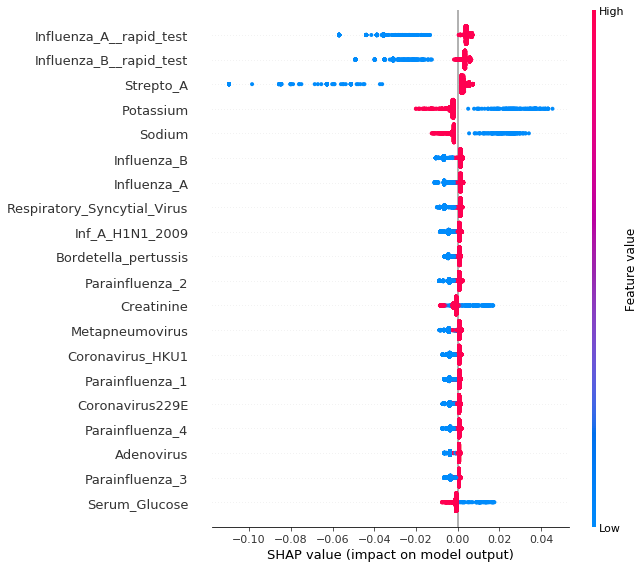

In [21]:
shap.summary_plot(shap_values[1], Xtr)

- engenharia reversa da decisão do médico de pedir exames...
- ainda pode ser útil:
    - o que leva um médico a pedir exame de sódio e potássio? o raciocínio pode ser usado para indicar covid 

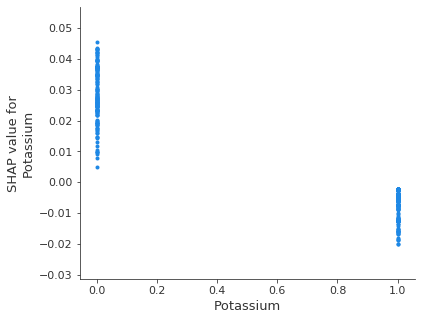

In [23]:
shap.dependence_plot('Potassium',shap_values[1], Xtr, interaction_index=None)

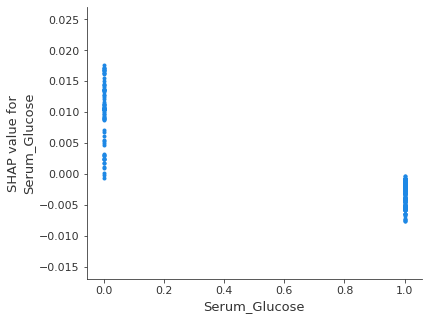

In [24]:
shap.dependence_plot('Serum_Glucose',shap_values[1], Xtr, interaction_index=None)

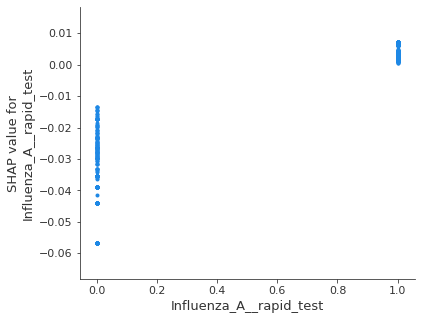

In [25]:
shap.dependence_plot('Influenza_A__rapid_test',shap_values[1], Xtr, interaction_index=None)
# por que a chance aumenta quando não tem esse exame?

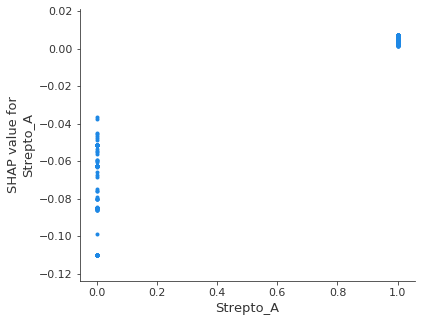

In [26]:
shap.dependence_plot('Strepto_A',shap_values[1], Xtr, interaction_index=None)
# por que a chance aumenta quando não tem esse exame?